In [1]:
import hashlib as hasher
import random

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
  count = 0
  for i in range (0 , len(hashStr)):
    if hashStr[i] == '1':
      break
    count += 1
  return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        #this below is new
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Miner:
  def __init__(self, miningPower, name, blockchain=None):
    self.miningPower = miningPower
    self.nonce = random.randint(0,100000)
    self.name = name
    self.blockchain = blockchain
    if self.blockchain != None:
      self.lastBlock = blockchain.longestChain()
  
  def UpdateLast(self):
    latest = self.blockchain.lastBlock()
    if latest.height > self.lastBlock.height:
        self.lastBlock = latest

  def PoWSolver(self):
    for i in range (0 , self.miningPower):
      newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
      h = newBlock.hash_block()
      count = numberOfInitZeros(h)
      if count >= bc.difficulty:
        self.blockchain.add(newBlock)
        self.lastBlock = newBlock
      self.nonce += 1
    
class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1
            
class Blockchain:
    def __init__(self, genesis_data, difficulty, protocol="longest"):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.protocol = protocol

    def lastBlock(self):
      if self.protocol == "longest":
        return self.longestChain()
      else:
        return self.heaviestChain(self.chain[0])
    
    def longestChain(self): 
      max = self.chain[0]
      for block in self.chain:
        if block.height > max.height:
          max = block
      return max

    def heaviestChain(self, root):
      if len(root.children) == 0:
        return root
      else:
        max = root.children[0]
        maxChilds = self.numberOfBlocksInSubtree(max)
        for block in root.children:
          tmp = self.numberOfBlocksInSubtree(block)
          if tmp > maxChilds:
            max = block
            maxChilds = tmp
        return self.heaviestChain(max)

    def numberOfBlocksInSubtree(self, block):
      if len(block.children) == 0:
        return 1
      else:
        sum = 0
        for b in block.children:
          sum += self.numberOfBlocksInSubtree(b)
        return 1 + sum

    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        
    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

In [2]:
def calc_percentage_of_total_profit(bc, miners):
    profit = 0
    bc_height = bc.longestChain().height
    for miner in miners:
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        profit += percentage_of_miner_blocks
    return profit

"""
A method that runs the simulation of mining

Inputs: 
- The blockchain instance (bc),
- An array of honest miners (honest_miners),
- An array of selfish miners (selfish_miners)

Outputs:
- The percentage of blocks mined by honest miners (honest_profit)
- The percentage of blocks mined by selfish miners (selfish_profit)
"""
def simulate_selfish_mining(bc, honest_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in honest_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in honest_miners:
            m.UpdateLast()
    
    selfish_profit = calc_percentage_of_total_profit(bc, selfish_miners)
    honest_profit = calc_percentage_of_total_profit(bc, honest_miners)
        
    return selfish_profit, honest_profit

### Mining Power Analysis and Simulation
## Simulation nr. 6: 

In [3]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""

## change this as well as simulatyion nr. 1
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 1, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for selfish_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round((100-selfish_power)/100, 2) 
    selfish_power_share = round(selfish_power/100, 2) 
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    bc = Blockchain("0" , 7, "ghost")

    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
    
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()

Running simulation of mining power with:
-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
...
Honest profit: 0.9999999999999994
Selfish profit: 0.0
Total profit: 0.9999999999999994

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

Running simulation of mining power with:
-> 99 honest minors having 98% of total mining power
-> 1 selfish minors having 2% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 97% of total mining power
-> 1 selfish minors having 3% of total mining power
...
Honest profit: 0.9736842105263162
Selfish profit: 0.02631578947368421
Total profit: 1.0000000000000004

Running simulation of mining po

Honest profit: 0.7377049180327873
Selfish profit: 0.26229508196721313
Total profit: 1.0000000000000004

Running simulation of mining power with:
-> 99 honest minors having 66% of total mining power
-> 1 selfish minors having 34% of total mining power
...
Honest profit: 0.7192982456140353
Selfish profit: 0.2807017543859649
Total profit: 1.0000000000000002

Running simulation of mining power with:
-> 99 honest minors having 65% of total mining power
-> 1 selfish minors having 35% of total mining power
...
Honest profit: 0.625
Selfish profit: 0.375
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 64% of total mining power
-> 1 selfish minors having 36% of total mining power
...
Honest profit: 0.7241379310344828
Selfish profit: 0.27586206896551724
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 63% of total mining power
-> 1 selfish minors having 37% of total mining power
...
Honest profit: 0.8305084745762709
Self

Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 31% of total mining power
-> 1 selfish minors having 69% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 30% of total mining power
-> 1 selfish minors having 70% of total mining power
...
Honest profit: 0.98
Selfish profit: 0.02
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 29% of total mining power
-> 1 selfish minors having 71% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 28% of total mining power
-> 1 selfish minors having 72% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 27% of total mining power
-> 1 selfi

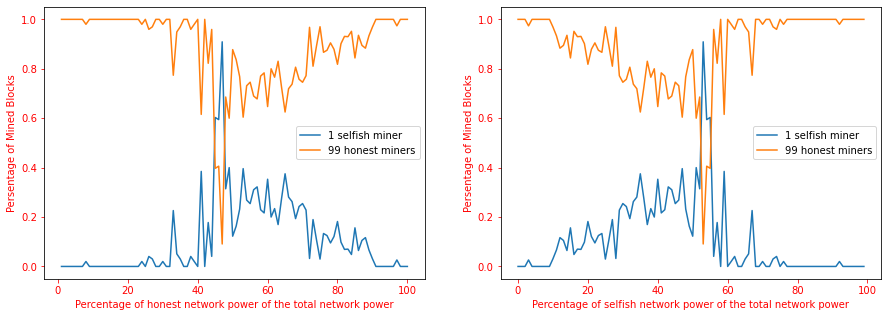

In [4]:
"""
Drawing the results of the previous simulation nr. ?????????????

--- A reminder of Simulation Details ---

"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "1 selfish miner")
axs[0].plot(honest_power, honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "1 selfish miner")
axs[1].plot(selfish_power, honest_profits, label = "99 honest miners")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

### Mining Power Analysis and Simulation
## Simulation nr. 6: 

In [5]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="honest", num_of_miners=60, total_mining_power=20)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 2, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)

    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    

Running simulation of mining power with:
-> 100 honest minors having 100% of total mining power
-> 0 selfish minors having 0% of total mining power
...
Honest profit: 0.9999999999999991
Selfish profit: 0
Total profit: 0.9999999999999991

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 0.999999999999999
Selfish profit: 0.0
Total profit: 0.999999999999999

Running simulation of mining power with:
-> 98 honest minors having 98% of total mining power
-> 2 selfish minors having 2% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 97 honest minors having 97% of total mining power
-> 3 selfish minors having 3% of total mining power
...
Honest profit: 0.9999999999999996
Selfish profit: 0.0
Total profit: 0.9999999999999996

Running simulation of mining power with:
-> 96 hon

Honest profit: 0.9999999999999992
Selfish profit: 0.0
Total profit: 0.9999999999999992

Running simulation of mining power with:
-> 65 honest minors having 65% of total mining power
-> 35 selfish minors having 35% of total mining power
...
Honest profit: 0.9615384615384617
Selfish profit: 0.038461538461538464
Total profit: 1.0000000000000002

Running simulation of mining power with:
-> 64 honest minors having 64% of total mining power
-> 36 selfish minors having 36% of total mining power
...
Honest profit: 0.7826086956521735
Selfish profit: 0.21739130434782608
Total profit: 0.9999999999999996

Running simulation of mining power with:
-> 63 honest minors having 63% of total mining power
-> 37 selfish minors having 37% of total mining power
...
Honest profit: 0.9215686274509806
Selfish profit: 0.0784313725490196
Total profit: 1.0000000000000002

Running simulation of mining power with:
-> 62 honest minors having 62% of total mining power
-> 38 selfish minors having 38% of total mining po

Honest profit: 0.8333333333333335
Selfish profit: 0.16666666666666666
Total profit: 1.0000000000000002

Running simulation of mining power with:
-> 32 honest minors having 32% of total mining power
-> 68 selfish minors having 68% of total mining power
...
Honest profit: 0.8666666666666666
Selfish profit: 0.13333333333333333
Total profit: 0.9999999999999999

Running simulation of mining power with:
-> 31 honest minors having 31% of total mining power
-> 69 selfish minors having 69% of total mining power
...
Honest profit: 0.9310344827586207
Selfish profit: 0.06896551724137931
Total profit: 1.0

Running simulation of mining power with:
-> 30 honest minors having 30% of total mining power
-> 70 selfish minors having 70% of total mining power
...
Honest profit: 0.6216216216216217
Selfish profit: 0.3783783783783784
Total profit: 1.0

Running simulation of mining power with:
-> 29 honest minors having 29% of total mining power
-> 71 selfish minors having 71% of total mining power
...
Honest 

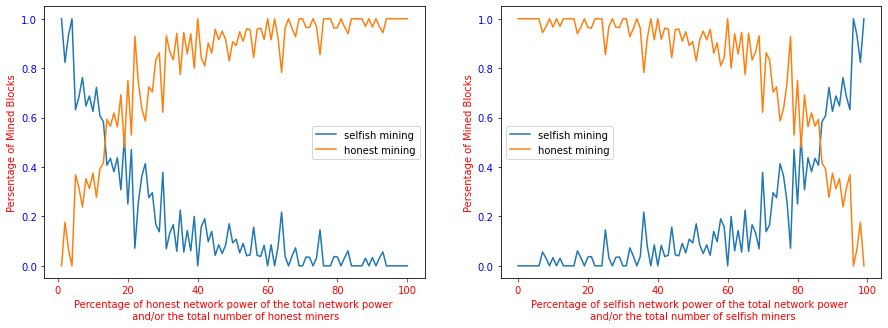

In [6]:
"""
Drawing the results of the previous simulation nr. 6

"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='blue')
axs[0].set_xlabel('Percentage of honest network power of the total network power \n and/or the total number of honest miners').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='blue')
axs[1].set_xlabel('Percentage of selfish network power of the total network power \n and/or the total number of selfish miners').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

# make average plot